In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Cloning Diffusers Git Repository

In [2]:
!git clone https://github.com/huggingface/diffusers

Cloning into 'diffusers'...
remote: Enumerating objects: 75726, done.
remote: Counting objects: 100% (1478/1478), done.
remote: Compressing objects: 100% (724/724), done.
remote: Total 75726 (delta 986), reused 1024 (delta 626), pack-reused 74248 (from 1)
Receiving objects: 100% (75726/75726), 54.50 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (56032/56032), done.


## Installing Dependencies

In [3]:
!pip install diffusers/

Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.32.0.dev0-py3-none-any.whl size=3120417 sha256=83f631606d51acb8e51e6e3080d4f210f6b8e22a95bffc1a2c68673ab97765c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-2lgorwan/wheels/f5/3d/4b/8e63ecf8f8467b91f49c2a926abe66393983fca5c47830e6e6
Successfully built diffusers


In [4]:
!pip install datasets

In [5]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 8.4 MB/s eta 0:00:00:00:01


In [6]:
!wandb login 3379b83ba7453f7ccc6a9c1d574b89bb2019df7f

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Command to Fine Tune "stable-diffusion-v1-4" using LORA architecture.

In [7]:
!accelerate launch /kaggle/working/diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
  --dataset_name="khadimhadi/my-hand-captioning-dataset_2" \
  --dataloader_num_workers=8 \
  --resolution=256 \
  --center_crop \
  --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --num_train_epochs=2 \
  --learning_rate=1e-05 \
  --max_grad_norm=0.5 \
  --lr_scheduler="cosine_with_restarts" \
  --lr_warmup_steps=500 \
  --output_dir="hands_output" \
  --report_to=wandb \
  --checkpointing_steps=300 \
  --checkpoints_total_limit=3\
  --validation_prompt="Generate an image that contains 10 hands showed separately" \
  --seed=42

scheduler/scheduler_config.json: 100%|█████████| 313/313 [00:00<00:00, 1.97MB/s]
{'dynamic_thresholding_ratio', 'sample_max_value', 'timestep_spacing', 'rescale_betas_zero_snr', 'thresholding', 'variance_type', 'clip_sample_range', 'prediction_type'} was not found in config. Values will be initialized to default values.
tokenizer/tokenizer_config.json: 100%|█████████| 806/806 [00:00<00:00, 5.05MB/s]
tokenizer/vocab.json: 100%|████████████████| 1.06M/1.06M [00:00<00:00, 4.19MB/s]
tokenizer/merges.txt: 100%|██████████████████| 525k/525k [00:00<00:00, 3.02MB/s]
text_encoder/config.json: 100%|████████████████| 592/592 [00:00<00:00, 4.48MB/s]
model.safetensors: 100%|██████████████████████| 492M/492M [00:02<00:00, 198MB/s]
vae/config.json: 100%|█████████████████████████| 551/551 [00:00<00:00, 3.36MB/s]
diffusion_pytorch_model.safetensors: 100%|████| 335M/335M [00:01<00:00, 223MB/s]
{'force_upcast', 'use_post_quant_conv', 'mid_block_add_attention', 'latents_std', 'norm_num_groups', 'shift_fac

- Rmoving any extra saved checkpoints (Optimization of RAM usage)

In [14]:
import shutil
shutil.rmtree('/kaggle/working/hands_output/checkpoint-1200')

## Loading the Pre-trained model and setting the Fine Tuned LORA weights

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from transformers import AutoTokenizer

In [ ]:
model_path = "/kaggle/working/hands_output"

# Load the base Stable Diffusion model
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype= torch.float16)
# Ensure it's using the GPU for better performance
pipeline = pipeline.to("cuda")  

In [10]:
# Load LoRA weights (assuming LoRA-compatible functionality or library is used)
# This functionality is specific to integrations or modifications.
try:
    pipeline.load_lora_weights(model_path)
    print("LoRA weights successfully loaded.")
except AttributeError:
    print("Ensure your diffusers library supports LoRA, and 'load_attn_procs' is available.")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

LoRA weights successfully loaded.


- Testing with a prompt

In [13]:
prompt = "Generate an image that contains 10 Hands separately"
image = pipeline(prompt).images[0]

# Save the image
image.save("output_image.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
prompt1 = "Generate an image that contains 10 Hands separately. Clearly shown their total 5 fingers ensuring all the hands should be separated. All those hands will be in a single frame."
image1 = pipeline(prompt1).images[0]

# Save the image
image1.save("output_image1.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
prompt2 = "Generate an image containing 10 hands, each with 5 fingers, without any people. Focus solely on the hands, ensuring that all fingers are clearly visible and anatomically correct."
image2 = pipeline(prompt2).images[0]

# Save the image
image2.save("output_image2.png")

  0%|          | 0/50 [00:00<?, ?it/s]

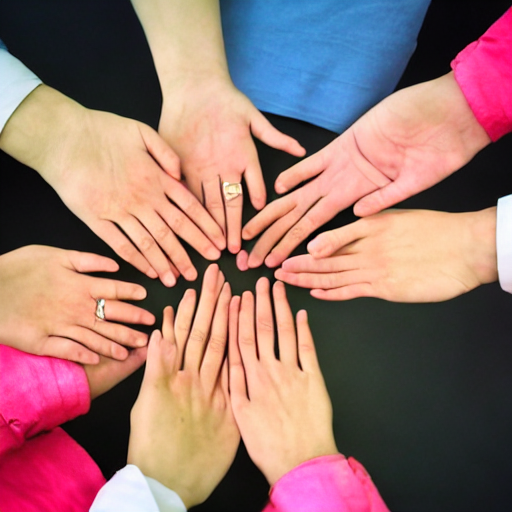

In [28]:
image

In [19]:
prompt3 = "Create an image showing 10 human hands arranged separately, all within a single frame. The hands should be detailed and diverse, appearing natural, with a mix of different skin tones."
image3 = pipeline(prompt3).images[0]

# Save the image
image3.save("output_image3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

### PixArt on Kaggle (Question 01 Testing)

In [15]:
from diffusers import DiffusionPipeline
 
pipe = DiffusionPipeline.from_pretrained("PixArt-alpha/PixArt-XL-2-1024-MS")

model_index.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

tokenizer/added_tokens.json:   0%|          | 0.00/2.63k [00:00<?, ?B/s]

(…)ext_encoder/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/9.06G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/2.45G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']


In [ ]:
!pip install ftfy

- Task 03 (5 people Handshake)

In [21]:
prompt3 = "Create an image showing five people standing in a single line, shaking hands with their adjacent neighbors, in a well-lit and neutral setting."
image3 = pipe(prompt3).images[0]


Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...


  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
image3.save("output_image6.png")

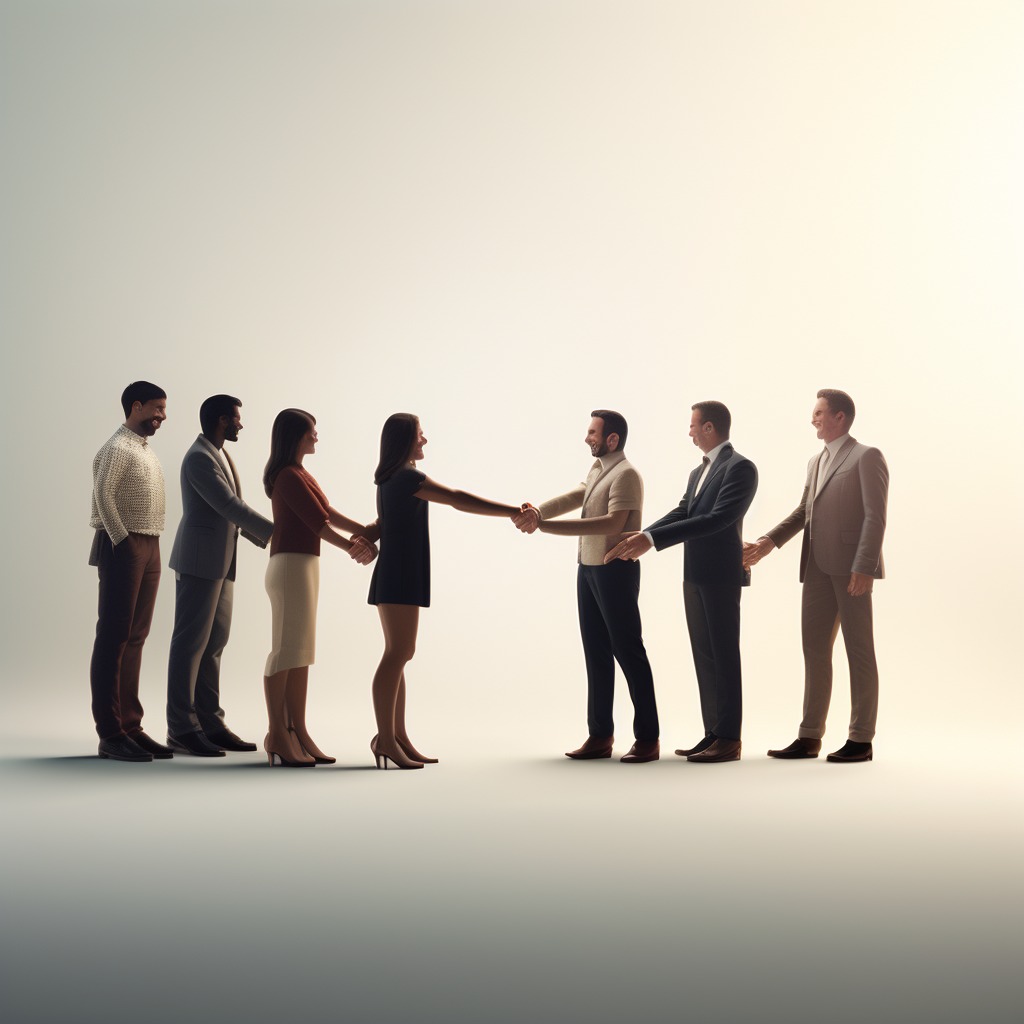

In [27]:
image3

- Task 02 (2 people Handshake)

In [24]:
prompt4 = "Create an image where five people are engaged in handshakes at the same time. The scene should convey a sense of unity and cooperation in a professional setting."
image4 = pipe(prompt4).images[0]


Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...

Setting `clean_caption=True` requires the ftfy library but it was not found in your environment. Checkout the instructions on the
installation section: https://github.com/rspeer/python-ftfy/tree/master#installing and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

Setting `clean_caption` to False...


  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
image4.save("output_image7.png")

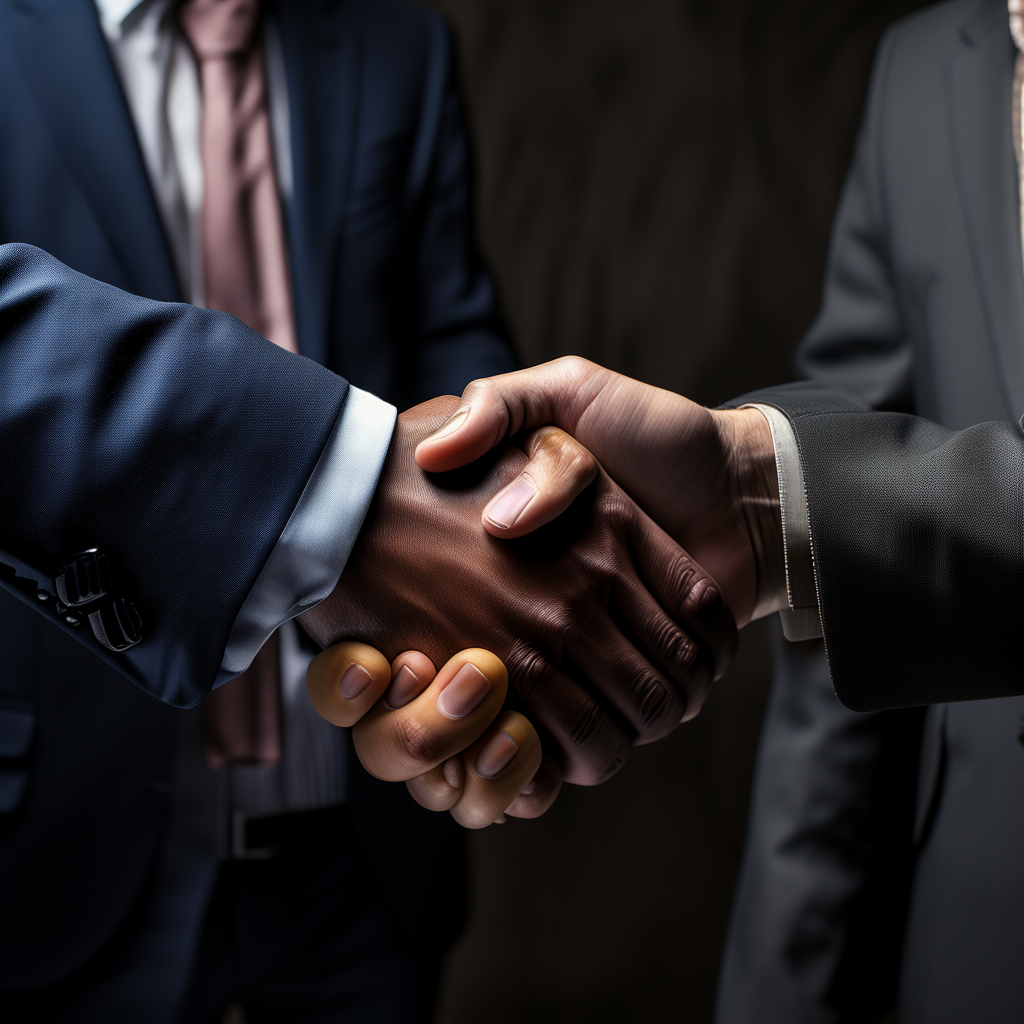

In [26]:
image4